# ***Extract, Load and Transform Data**

## Objectives

* Extract and prepare the Kaggle synthetic credit card transactions dataset for analysis and modelling. Specifically:
- Validate dataset structure.
- Perform exploratory quality checks (missing values, duplicates, ranges).
- Clean and standardise data.
- Engineer features to improve interpretability and model performance.

## Inputs

* Sampled Kaggle Credit Card Fraud Dataset data/raw/card_transdata_sample_100k.csv (this was produced from full dataset downloaded from https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data/code).

**What this notebook does:**

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

I need to change the working directory from the current folder to its parent folder (required because the notebook is being run from inside the jupyter notebooks subfolder). In the code below, I change the working directory from its current folder to its parent folder.  
* I access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\DA_Capstone\\Credit-Card-Fraud-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\DA_Capstone\\Credit-Card-Fraud-Analysis'

---
# Section 1: Data Load (Pre-Created 100k Sample)
**About the Dataset:**

This notebook works with a pre-created stratified sample of 100,000 rows from a larger synthetic credit card fraud dataset (originally 1M rows). The sample preserves the fraud class balance (8.74% fraud rate) and was created using stratified sampling.

**Sample Creation Details:**
- Original dataset: 1,000,000 rows, 87,403 fraud cases (8.74%)
- Sample dataset: 100,000 rows, 8,740 fraud cases (8.74%)
- Method: Stratified sampling via sklearn.model_selection.train_test_split
- Random seed: 42 (for reproducibility)
- Validation: data/raw/sample_log.json for full metadata and checksums

**In this section:**
- Load the 100k stratified sample from data/raw/card_transdata_sample_100k.csv
- Conduct basic shape and structure checks
- Verify data loaded correctly before proceeding to cleaning and feature engineering

Section 1 content

In [4]:
# Load libraries and the 100k stratified sample dataset

from pathlib import Path # load the pathlib library

import numpy as mp # load the numpy library
import pandas as pd # load the pandas library
import matplotlib.pyplot as plt # load the matplotlib library
import seaborn as sns # load the seaborn library
import json # for reading sample metadat

# load the 100k stratified sample dataset
df = pd.read_csv('data/raw/card_transdata_sample_100k.csv') # load the dataset

print(df.head()) # display the first 5 rows of the dataframe (use print as multiple outputs are not supported in script, single output no print needed)

print(df.shape) # display the shape of the dataframe

# Display fraud rate and counts clearly
fraud_count = int(df['fraud'].sum()) # count the number of fraud cases
fraud_rate = df['fraud'].mean() # calculate the fraud rate
total_rows = df.shape[0] # get the total number of transactions
print(f"Fraud rate: {fraud_rate:.4%} ({fraud_count} fraud cases out of {total_rows} total transactions)") # display fraud rate and counts clearly

   distance_from_home  distance_from_last_transaction  \
0           19.179396                        0.178758   
1           47.192898                        1.224832   
2           54.389043                        5.290910   
3            3.129745                        0.607212   
4            0.925275                        2.238057   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        2.979353              1.0        0.0   
1                        0.293538              1.0        1.0   
2                        4.492304              1.0        1.0   
3                        0.357527              1.0        0.0   
4                        0.684942              0.0        0.0   

   used_pin_number  online_order  fraud  
0              0.0           1.0    0.0  
1              0.0           1.0    0.0  
2              0.0           0.0    0.0  
3              0.0           1.0    0.0  
4              0.0           0.0    0.0  
(100000, 8)
Fr

---

# Section 2 Data Structure and Quality Check

Section 2 content

In [5]:
#  Basic structure of the dataframe and quality check

print("Dataset shape:") # Print "Dataset shape" before next print output for clarity
print(df.shape) # display the shape of the dataframe

print("\nColumn information:") # write "column information" before next print output for clarity

# Check data types, non-null counts and missing values and create summary table
summary = (
    pd.DataFrame({
    'Data Type': df.dtypes, # data types
    'Non-Null Count': df.notnull().sum(), # non-null counts
    'Missing Values': df.isnull().sum(),
   "missing_pct": (df.isna().mean()*100).round(3),  # percent missing NaN values per column 
    'Unique Values': df.nunique() # unique values
})
.sort_values(by='Missing Values', ascending=False) # sort by missing values

)

summary  # display the summary table

Dataset shape:
(100000, 8)

Column information:


,Data Type,Non-Null Count,Missing Values,missing_pct,Unique Values
distance_from_home,float64,100000,0,0.0,100000
distance_from_last_transaction,float64,100000,0,0.0,100000
ratio_to_median_purchase_price,float64,100000,0,0.0,100000
repeat_retailer,float64,100000,0,0.0,2
used_chip,float64,100000,0,0.0,2
used_pin_number,float64,100000,0,0.0,2
online_order,float64,100000,0,0.0,2
fraud,float64,100000,0,0.0,2


In [6]:
 # check for duplicate rows
duplicate_rows = df.duplicated().sum() # count duplicate rows
print(f"\nNumber of duplicate rows: {duplicate_rows}") # adds text to the output stating number of duplicate rows for clarity


Number of duplicate rows: 0


In [7]:
# Validate ranges are sensible for continuous variables
print("\nValue Range Validation (Continuous Variables):") # adds text to the output before the range validation for clarity
print("-" * 50) # --- separator line for clarity

cont_cols = ["distance_from_home", 
             "distance_from_last_transaction", 
             "ratio_to_median_purchase_price"] # list of continuous variable columns

for col in cont_cols:
    min_val = df[col].min() # calculate minimum value
    max_val = df[col].max() # calculate maximum value
    print(f"{col:35s}: min={min_val:8.3f}, max={max_val:8.3f}") # formatted print for clarity

# Check for any negative values (should be none)
negative_counts = (df[cont_cols] < 0).sum() # count negative values in continuous variables
print("\nNegative Value Counts (Continuous Variables):") # adds text to the output before the
if negative_counts.sum() > 0: # if there are any negative values
    print(negative_counts[negative_counts > 0]) # display counts of negative values
else:
    print("\n✓ All continuous variables have valid non-negative values") # confirmation message if no negative values


Value Range Validation (Continuous Variables):
--------------------------------------------------
distance_from_home                 : min=   0.025, max=5797.973
distance_from_last_transaction     : min=   0.000, max=4968.315
ratio_to_median_purchase_price     : min=   0.007, max= 266.690

Negative Value Counts (Continuous Variables):

✓ All continuous variables have valid non-negative values


# Section 3: Descriptive Stats Review for all Variables 

In [8]:
# Summary Stats for all variables
df.describe(include='all')# display summary statistics for all variables in the dataframe


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,26.681624,5.048395,1.832806,0.880780,0.34857,0.101290,0.651250,0.087400
std,67.723706,28.179679,2.883186,0.324049,0.47652,0.301714,0.476577,0.282422
min,0.024602,0.000434,0.007427,0.000000,0.00000,0.000000,0.000000,0.000000
25%,3.875510,0.293744,0.476066,1.000000,0.00000,0.000000,0.000000,0.000000
50%,9.942868,0.997630,1.002759,1.000000,0.00000,0.000000,1.000000,0.000000
75%,25.717717,3.358880,2.102391,1.000000,1.00000,0.000000,1.000000,0.000000
max,5797.972589,4968.315477,266.689692,1.000000,1.00000,1.000000,1.000000,1.000000


---

# Section 4: Distribution and Outlier Checks


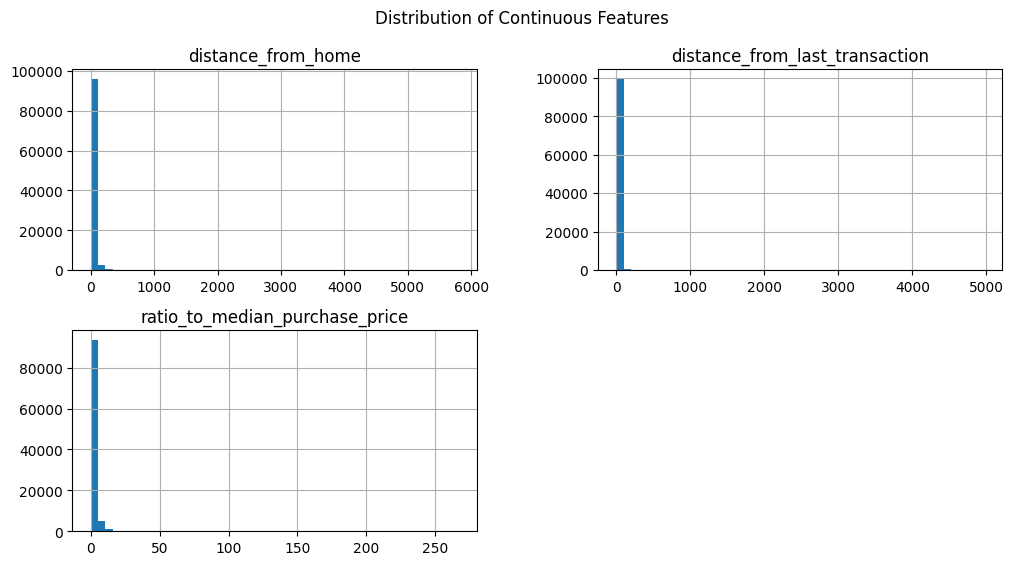

In [9]:
# Histograms for continuous variables
cont_cols = ["distance_from_home", 
             "distance_from_last_transaction", 
             "ratio_to_median_purchase_price"] # list of continuous variable columns

df[cont_cols].hist(bins=50, figsize=(12,6)) # plot histograms for continuous columns 
plt.suptitle("Distribution of Continuous Features") # add a title
plt.show() # display the plots

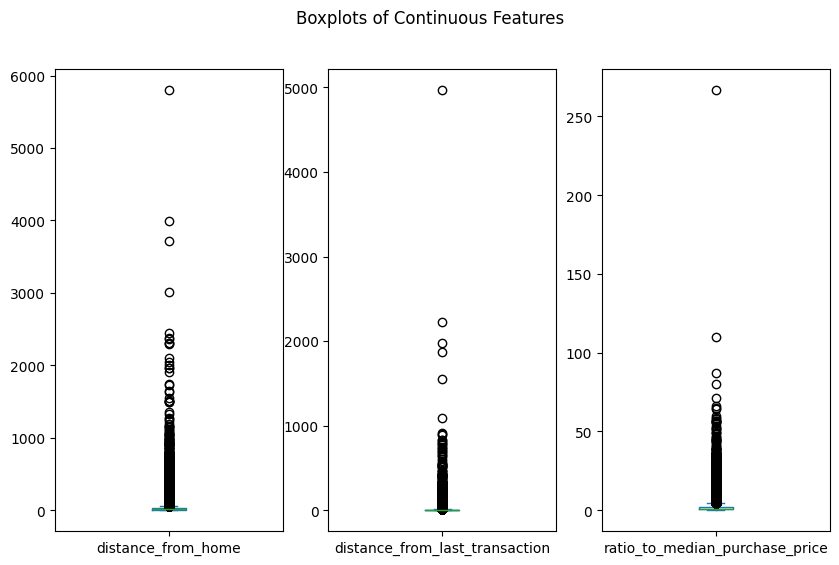

In [10]:
# Boxplots for continuous variables to check for outliers
df[cont_cols].plot(kind='box', subplots=True, layout=(1,3), figsize=(10,6)) # plot boxplots for continuous columns
plt.suptitle("Boxplots of Continuous Features") # add a title
plt.show() # display the plots

In [11]:
# IQR method to identify outliers
for col in cont_cols:
    Q1 = df[col].quantile(0.25) # first quartile
    Q3 = df[col].quantile(0.75) # third quartile
    IQR = Q3 - Q1 # interquartile range
    lower_bound = Q1 - 1.5 * IQR # lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR # upper bound for outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)] # identify outliers
    print(f"{col:35s}: {len(outliers)} outliers (IQR method)") # formatted print of number of outliers

distance_from_home                 : 10397 outliers (IQR method)
distance_from_last_transaction     : 12469 outliers (IQR method)
ratio_to_median_purchase_price     : 8464 outliers (IQR method)


---
# Section 5: Binary Feature Checks


repeat_retailer value counts:
repeat_retailer
1    0.881
0    0.119
Name: proportion, dtype: float64

used_chip value counts:
used_chip
0    0.651
1    0.349
Name: proportion, dtype: float64

used_pin_number value counts:
used_pin_number
0    0.899
1    0.101
Name: proportion, dtype: float64

online_order value counts:
online_order
1    0.651
0    0.349
Name: proportion, dtype: float64

fraud value counts:
fraud
0    0.913
1    0.087
Name: proportion, dtype: float64


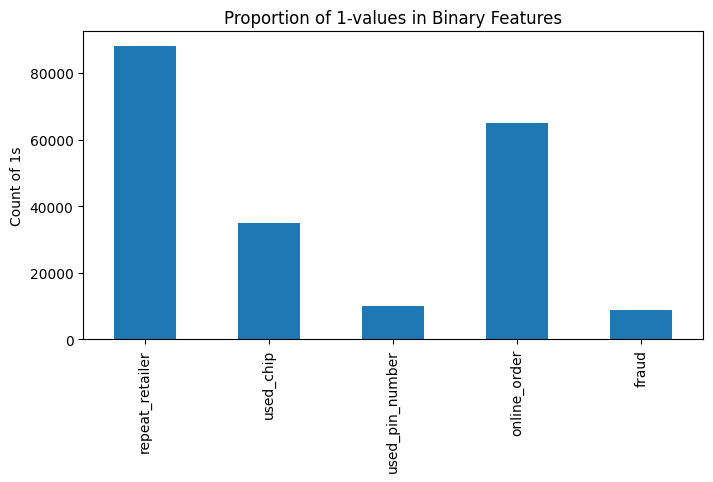

In [15]:
# Binary feature checks
binary_cols = ["repeat_retailer", # list of binary variable columns
               "used_chip", 
               "used_pin_number", 
               "online_order", 
               "fraud"]

# Display value counts for binary columns
for col in binary_cols: # iterate over binary columns
    print(f"\n{col} value counts:") # print column name before value counts for clarity
    print(df[col].value_counts(normalize=True).round(3)) # display value counts for binary columns

# Quick bar plots (Matplotlib) 

df[binary_cols].astype(int).sum().plot(kind="bar", figsize=(8,4)) # bar plot of sum of 1s in binary columns
plt.title("Proportion of 1-values in Binary Features") # add title
plt.ylabel("Count of 1s") # add y-axis label
plt.show() #

# Convert Binary columns to integer type if not already

In [16]:
# Covert Binary columns to integer type if not already
binary_cols = ["repeat_retailer",
                "used_chip",
                 "used_pin_number", 
                 "online_order", 
                 "fraud"] # list of binary variable columns
df[binary_cols] = df[binary_cols].astype(int) # convert binary columns to integer type
df[binary_cols].dtypes # display data types of binary columns to confirm conversion

repeat_retailer    int32
used_chip          int32
used_pin_number    int32
online_order       int32
fraud              int32
dtype: object

---
# Section 6: Correlation Heatmap


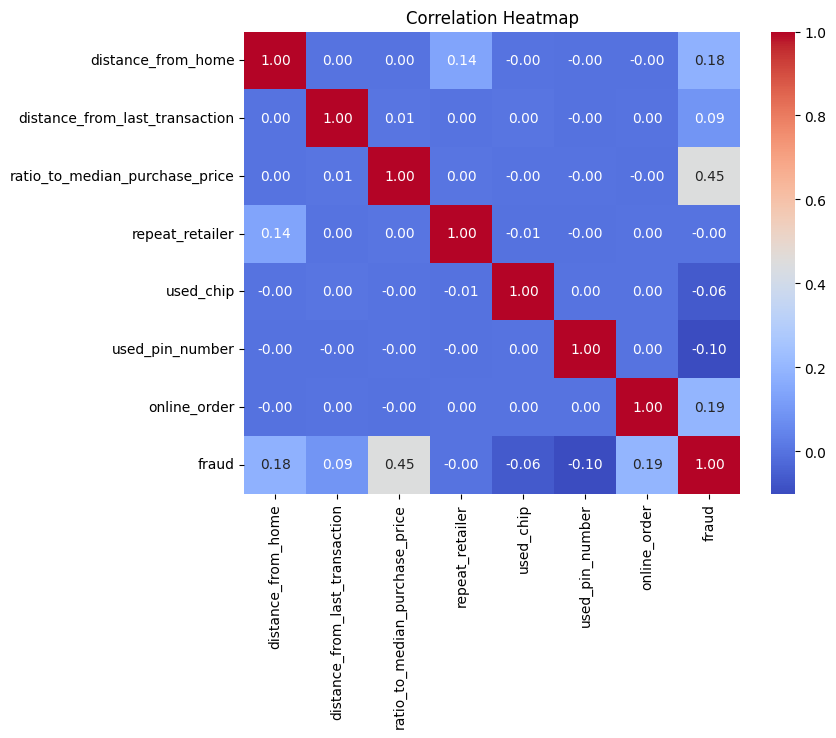

In [17]:
# Correlation Heatmap with Seaborn

corr = df.corr() # calculate the correlation matrix

plt.figure(figsize=(8,6)) # set figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True) # plot the heatmap with annotations
plt.title("Correlation Heatmap") # add a title
plt.show() # display the plott.show() # display the plot